[Ressource]
 https://github.com/RaRe-Technologies/gensim/blob/3c3506d51a2caf6b890de3b1b32a8b85f7566ca5/docs/notebooks/doc2vec-IMDB.ipynb
[PV-DM]
 https://cs.stanford.edu/~quocle/paragraph_vector.pdf

Doc2Vec DOcumentation:
https://radimrehurek.com/gensim/models/doc2vec.html

In [2]:

import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar") 
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt 

/Users/remy.d.w/.virtualenvs/PROROK/untitled/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Import the dataset 

We will build a function that can load the dataset and return a dataframe 

In [3]:

def loadData(path, delimiter=','):
    df = pd.read_csv(path, delimiter=delimiter)
    return df 

dataset_path = './data/Consumer_Complaints.csv'

df = loadData(path=dataset_path)

df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,08/09/2015,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,Company chooses not to provide a public response,Experian Information Solutions Inc.,NJ,08872,NaN,Consent not provided,Web,08/09/2015,Closed with non-monetary relief,Yes,No,1509954.0
1,01/29/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"EQUIFAX, INC.",NY,10801,NaN,Consent not provided,Web,01/30/2019,Closed with non-monetary relief,Yes,NaN,3136759.0
2,10/13/2019,Debt collection,I do not know,Attempts to collect debt not owed,Debt was result of identity theft,NaN,NaN,SANTANDER CONSUMER USA HOLDINGS INC.,GA,300XX,Servicemember,NaN,Web,10/13/2019,Closed with explanation,Yes,NaN,3404213.0
3,08/19/2015,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,Company chooses not to provide a public response,WELLS FARGO & COMPANY,CA,94526,NaN,Consent not provided,Web,08/19/2015,Closed with explanation,Yes,No,1527601.0
4,03/04/2016,Credit card,NaN,Billing disputes,NaN,I am dissatisfied with the current outcome of ...,NaN,DISCOVER BANK,NV,891XX,NaN,Consent provided,Web,03/04/2016,Closed with explanation,Yes,Yes,1816726.0


In [4]:
df.describe()

,Complaint ID
count,1.537290e+05
mean,1.965315e+06
std,9.727821e+05
min,4.800000e+01
25%,1.160423e+06
50%,2.165474e+06
75%,2.820116e+06
max,3.427958e+06


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153733 entries, 0 to 153732
Data columns (total 18 columns):
Date received                   153733 non-null object
Product                         153730 non-null object
Sub-product                     125167 non-null object
Issue                           153730 non-null object
Sub-issue                       92521 non-null object
Consumer complaint narrative    48704 non-null object
Company public response         55871 non-null object
Company                         153729 non-null object
State                           151367 non-null object
ZIP code                        140081 non-null object
Tags                            20956 non-null object
Consumer consent provided?      86392 non-null object
Submitted via                   153729 non-null object
Date sent to company            153729 non-null object
Company response to consumer    153729 non-null object
Timely response?                153729 non-null object
Consumer dispu


We are only interested by the narrative. This are message that consumer let. We will classify those narrative by product type.
But first we need to remove all the empty narrative.

In [6]:
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)

df = df[pd.notnull(df['narrative'])]

In [7]:
df.iloc[:, 5:]

,narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
4,I am dissatisfied with the current outcome of ...,NaN,DISCOVER BANK,NV,891XX,NaN,Consent provided,Web,03/04/2016,Closed with explanation,Yes,Yes,1816726.0
8,On XX/XX/18 an item showed up on my credit rep...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",VA,245XX,NaN,Consent provided,Web,03/03/2018,Closed with explanation,Yes,NaN,2831821.0
9,Saw on my credit report that there is a collec...,Company believes complaint caused principally ...,"Cascade Capital, LLC",FL,334XX,Older American,Consent provided,Web,01/18/2019,Closed with explanation,Yes,NaN,3114357.0
10,Capital one auto finacing XX/XX/2018 unknown i...,NaN,CAPITAL ONE FINANCIAL CORPORATION,MD,212XX,NaN,Consent provided,Web,12/23/2018,Closed with explanation,Yes,NaN,3108212.0
12,I own a small trucking company. One of my truc...,NaN,TD BANK US HOLDING COMPANY,NJ,NaN,NaN,Consent provided,Web,04/16/2018,Closed with monetary relief,Yes,NaN,2874325.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153714,I am a victim of identity theft. Several years...,Company believes it acted appropriately as aut...,UNITED SERVICES AUTOMOBILE ASSOCIATION,TX,78746,NaN,Consent provided,Web,08/16/2016,Closed with explanation,Yes,No,2063908.0
153716,XXXX XXXX is reporting inaccurate information ...,Company believes it acted appropriately as aut...,Equitable Acceptance Corporation,UT,840XX,NaN,Consent provided,Web,12/20/2018,Closed with explanation,Yes,NaN,3090158.0
153717,We submitted all our info and got preapproved....,NaN,SIERRA PACIFIC MORTGAGE,IN,NaN,NaN,Consent provided,Web,08/31/2016,Closed with explanation,Yes,No,2090317.0
153720,I received a credit alert from XXXX stating th...,NaN,Midwest Recovery Systems,FL,349XX,NaN,Consent provided,Web,04/18/2018,Closed with explanation,Yes,NaN,2878722.0


In [8]:
df_narrative = df[['narrative', 'Product']]

In [9]:
df_narrative.describe()

,narrative,Product
count,48704,48704
unique,48104,18
top,There are many mistakes appear in my report wi...,"Credit reporting, credit repair services, or o..."
freq,120,12668



We can see that there are 18 different product type and  48704 narrative.

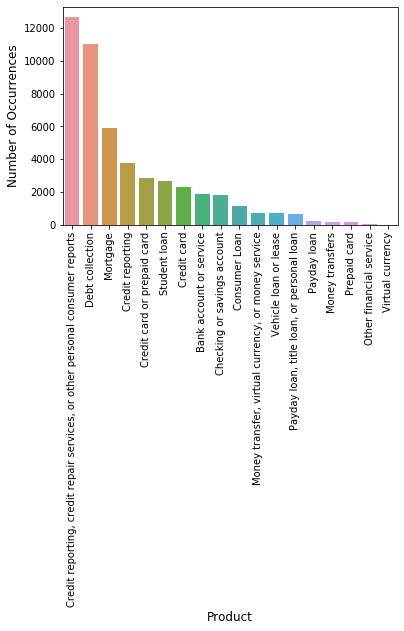

In [10]:
cnt_product = df["Product"].value_counts()

sns.barplot(cnt_product.index, cnt_product.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

# Data cleaning 

First step we are going to tokenize the data. And next we are going to remove all the stop word and do lemming. 
We just need to take the code that we have implemented in the LDA kernel.

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

import spacy.cli
from spacy.lang.fr import French
spacy.cli.download("fr_core_news_sm")
spacy_nlp = spacy.load('fr_core_news_sm')

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [12]:
parser = French()

tokenizer = French()

stop_words = spacy.lang.fr.STOP_WORDS

punctuations = spacy.lang.fr.punctuation.LIST_PUNCT

def easy_tokenizer(sentence):
    """
    
    :param sentence: the texte we want to treat with our parser 
    :return: 
    """
    # creating our token object 
    easy_tokens = parser(sentence)
    
    # lemming  and lowering. Stripping white space 
    # if the word is not a Pronoun lower the word and strip space else return the lower word. 
    # Because  spacy replace pronouns by "-PRON-" on lemming call. as we need the pronoun we can not do its lemmatization
    
    easy_tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower() for word in easy_tokens ]
    
    # remove stop words 
    easy_tokens = [word  for word in easy_tokens if (word not in stop_words and word not in punctuations)]

    
    return easy_tokens

In [13]:
train, test = train_test_split(df, random_state=42, test_size=0.3)
print("OK")

OK


In [14]:
e_tokenizer_lambda = lambda d : TaggedDocument(words=easy_tokenizer(d['narrative']), tags=[d.Product])
train_tagged = train.apply(e_tokenizer_lambda, axis=1)
test_tagged = test.apply(e_tokenizer_lambda, axis=1)

In [15]:

train_tagged.values[1:10]

array([TaggedDocument(words=['opened', 'new', 'bank', 'of', 'america', 'credit', 'card', 'in', 'xx', '/', 'xx', '/', 'xxxx', 'in', 'one', 'day', 'to', 'the', 'other', 'two', 'weeks', 'later', 'they', 'just', 'closed', 'it', 'down', '.', 'and', 'when', 'called', 'them', 'they', 'told', 'that', 'have', 'very', 'good', 'credit', 'they', 'just', 'want', 'should', 'go', 'down', 'to', 'branch', 'with', 'my', 'license', '.', 'went', 'down', 'to', 'fax', 'the', 'documents', 'that', 'they', 'needed', 'and', 'still', 'they', "don'", 't', 'want', 'to', 'open', 'up', 'the', 'card', '.', "that'", 's', 'real', 'discrimination', 'have', 'good', 'relationship', 'with', 'all', 'the', 'banks', 'and', 'they', 'should', 'open', 'the', 'account', 'soon'], tags=['Credit card or prepaid card']),
       TaggedDocument(words=['equifax', "'", 's', 'hacked', 'system', 'compromised', 'my', 'personal', 'identifying', 'information', '.', "'", 've', 'had', 'to', 'spend', 'countless', 'hours', 'to', 'ensure', 'am', '

The apply function apply the "e_tokenizer_lambda"  to each narrative row. Each row is now a TaggedDocument. 
Each narrative is matched with is corresponding product type.


# Build the vocabulary 

We are going to build two model. One that use the PV-DM algorithm and the other the PV-CBOW algorithm. Le and Mikolov 
notes that combining a paragraph vector from Distributed Bag of Words (DBOW) and Distributed Memory (DM)
improves performance. We will concatenate the output of the two models.

* If dm=0, distributed bag of words (PV-DBOW) is used; if dm=1,‘distributed memory’ (PV-DM) is used.
* 300- dimensional feature vectors. (In the research paper they use 400) 
* min_count=2, ignores all words with total frequency lower than this.
* negative=5 , specifies how many “noise words” should be drawn.
* hs=0 , and negative is non-zero, negative sampling will be used.
* sample=0 , the threshold for configuring which higher-frequency words are randomly down sampled.
* workers=cores , use these many worker threads to train the model (=faster training with multicore machines).

In [16]:
import multiprocessing
cores = multiprocessing.cpu_count()


model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 34092/34092 [00:00<00:00, 1163465.30it/s]


In [17]:
model_dm = Doc2Vec(dm=1, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dm.build_vocab([x for x in tqdm(train_tagged.values)])


100%|██████████| 34092/34092 [00:00<00:00, 950505.94it/s]


We arre going to train the two model on 20 epochs.
the learning rate will be decrease of 0.2% each epoch.

## PV-CBOW

In [18]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha


100%|██████████| 34092/34092 [00:00<00:00, 1379914.04it/s]


CPU times: user 6min 58s, sys: 11.7 s, total: 7min 10s
Wall time: 2min 30s


## PV-DM

In [19]:
for epoch in range(30):
    model_dm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dbow.alpha


100%|██████████| 34092/34092 [00:00<00:00, 2611443.71it/s]


Let's check the result after training we are going to check the most similar words to 
'hope' a word that is contains in the vocabulary.

Note: If the word is not present in the vocab. The function return an exception.

Info : 
Infer_vector : function looks for a DocVector that closer to the Document in parameter 

In [20]:
vec = model_dm.infer_vector(doc_words=train_tagged.values[4].words, steps=20, alpha=0.025)

The result is pretty good. The most closer word to 'hope' is 'pray'. 

In [21]:
model_dm.most_similar(positive='hope', topn=10) # ten most similar 

/Users/remy.d.w/.virtualenvs/PROROK/untitled/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('appreciate', 0.762397050857544),
 ('hopefully', 0.7430069446563721),
 ('pray', 0.7394447326660156),
 ('imagine', 0.7271996736526489),
 ('remind', 0.726472020149231),
 ('shame', 0.7203212380409241),
 ('guys', 0.6975152492523193),
 ('urge', 0.6968690156936646),
 ('cooperation', 0.6944521069526672),
 ('claimant', 0.6938045024871826)]

  Get the trained document vector, and most similar document to the tag "Credit reporting"

In [22]:
model_dm.docvecs.most_similar(positive='Credit reporting', negative='Checking or savings account', topn=10)

TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
# concatenate the model

from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
model = ConcatenatedDoc2Vec([model_dbow, model_dm])

In [ ]:
out = model_dm.docvecs.count
out 


# Trainning 

We will train 4 differents machine learning algorithm to predict the output :

* Logistic regression 
* Linear-SVC
* Naives-Bayes
* XGBoost

Vec_for_learning :
The inference tries to fit a later example into a frozen model, and so if you re-present the same document, it should 
wind up 'close' to the vector that the same document induced in multi-pass bulk training. But how 'close' would depend 
on a lot of things. The information in the PV paper about parameter choices is limited.

In [ ]:
def vec_for_learning(doc2vec_model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors


## Logistic regression 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
log_reg = LogisticRegression()

y_train, X_train = vec_for_learning(model, train_tagged)
y_test, X_test = vec_for_learning(model, test_tagged)

In [ ]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
